In [1]:
import requests
import pandas as pd
import numpy as np
from dateutil import parser
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os

import spacy
from wordcloud import WordCloud, STOPWORDS

In [2]:
#!python -m spacy download en_core_web_sm
host = 'http://18.188.56.207:9200/'
requests.get(host + '_cat/indices/enron').content

b'yellow open enron UGlaTU5HQD2KjPcr0kmCmQ 1 1 251734 0 540.9mb 540.9mb\n'

In [3]:
nlp = spacy.load("en_core_web_sm")

In [4]:
def elasticsearch_results_to_df(results):
    '''
    A function that will take the results of a requests.get 
    call to Elasticsearch and return a pandas.DataFrame object 
    with the results 
    '''
    hits = results.json()['hits']['hits']
    data = pd.DataFrame([i['_source'] for i in hits], index = [i['_id'] for i in hits])
    data['date'] = data['date'].apply(parser.parse)
    return(data)

def print_df_row(row):
    '''
    A function that will take a row of the data frame and print it out
    '''
    print('____________________')
    print('RE: %s' % row.get('subject',''))
    print('At: %s' % row.get('date',''))
    print('From: %s' % row.get('sender',''))
    print('To: %s' % row.get('recipients',''))
    print('CC: %s' % row.get('cc',''))
    print('BCC: %s' % row.get('bcc',''))
    print('Body:\n%s' % row.get('text',''))
    print('____________________')


In [5]:
doc = {
  "query": {
    "query_string": {
      "query":    "JEDI OR raptor OR LJM OR whitewing",
      "fields": [ "text"]
    }
  },
    "from" : 0, # Starting message to return. 
    "size" : 10000, # Return this many messages. Can't be more than 10,000
}
r=requests.get(host + 'enron/_search',
               data=json.dumps(doc), headers={'Content-Type':'application/json'})
r.raise_for_status()
print("Found %s messages matching the query, of " % r.json()['hits']['total'])
df = elasticsearch_results_to_df(r)
print("Returned %s messages" % df.shape[0])

Found {'value': 691, 'relation': 'eq'} messages matching the query, of 
Returned 691 messages


In [6]:
doc_set = {}
doc_span = []

for row in df['text'].values:
    doc = nlp(row)
    doc_span.extend(doc.ents)
    for ent in doc.ents:
        doc_set[ent.text] = ent.label_

In [7]:
def wordListToFreqDict(wordlist):
    wordfreq = [wordlist.count(p) for p in wordlist]
    return dict(list(zip(wordlist,wordfreq)))

In [8]:
doc_lst = [x.text for x in doc_span]
doc_freq = wordListToFreqDict(doc_lst)
doc_freq_sorted = sorted(doc_freq.items(), key=lambda x: x[1], reverse=True)

In [9]:
#Plot only top 50
doc_df = pd.DataFrame(doc_freq_sorted[0:50], columns =['Term', 'Count'])

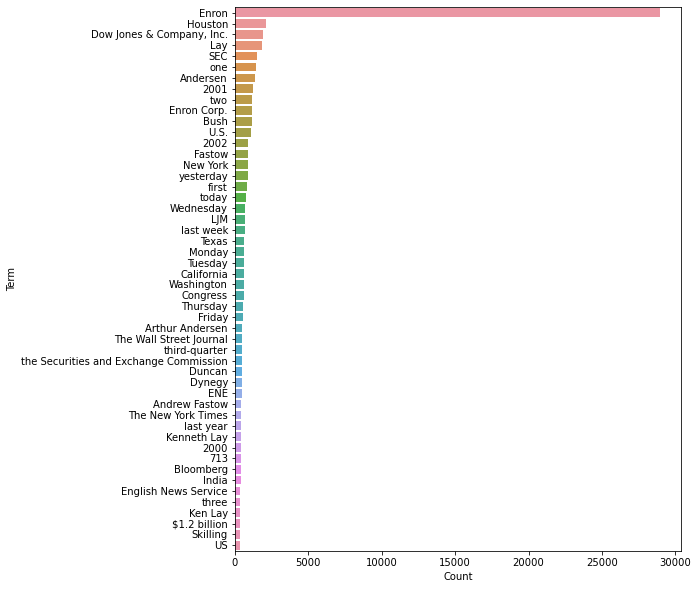

In [10]:
plt.figure(figsize=(8, 10))
ax = sns.barplot(y="Term", x="Count", data=doc_df)

In [11]:
stopwords = set(STOPWORDS)
wordcloud_txt = " ".join(x for x in doc_lst)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(wordcloud_txt)

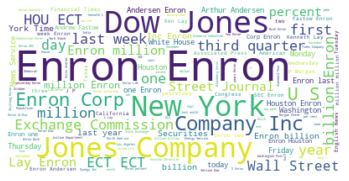

In [12]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()